## Imports

In [112]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel, RandomForestReg, RnnDlModel_test 
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting data

In [73]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [74]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [75]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [61]:
np.array(Y_test_list).shape

(32, 90)

In [62]:
train_df.head(3)

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
0,2018-02-01,2.054109e+19,830,5642.903220,16839700.0,2000.0,842398,377,257504,27026398,...,0.003691,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.235616
1,2018-02-02,2.170824e+19,829,5641.695528,16841800.0,2100.0,854253,385,235750,26955617,...,0.002557,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.260491
2,2018-02-03,2.073919e+19,828,5641.015128,16843775.0,1975.0,714655,384,194733,26886977,...,0.001970,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.230759


## Data viz exploration

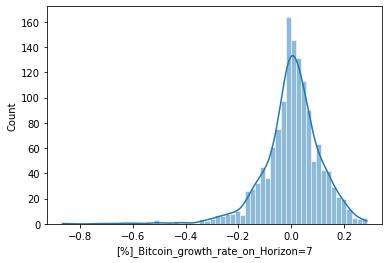

In [7]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

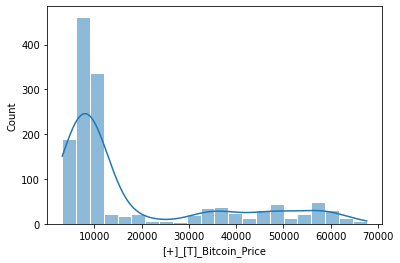

In [8]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [154]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 4, figsize = (25,200))
    scores = []
    for k in range(5):#range(len(X_train_list)): #
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        y_pred = model.run(X_test, X_train, y_train)
        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].set_ylabel('Price growth rate 7 days')
        axs[k, 0].set_xlabel('Fold sequence lenght in days')
        axs[k, 0].legend(loc='upper right')
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].set_ylabel('Price growth rate 7 days')
        axs[k, 1].set_xlabel('Fold sequence lenght in days')
        axs[k, 1].legend(loc='upper right');
        axs[k, 2].plot(model.history.history['mae'], color = 'y', label = 'mae')
        axs[k, 2].plot(model.history.history['val_mae'], color = 'b', label = 'val_mae')
        axs[k, 2].set_title('model mae')
        axs[k, 2].set_ylabel('mae')
        axs[k, 2].set_xlabel('epoch')
        axs[k, 2].legend(['train', 'test'], loc='upper right')
        axs[k, 3].plot(model.history.history['loss'], color = 'y', label = 'mae')
        axs[k, 3].plot(model.history.history['val_loss'], color = 'b', label = 'val_mae')
        axs[k, 3].set_title('model train vs validation loss')
        axs[k, 3].set_ylabel('loss')
        axs[k, 3].set_xlabel('epoch')
        axs[k, 3].legend(['train', 'validation'], loc='upper right')
        if k == 1:
            print(model.model.summary())
        print(f'############### next fold => number {k} ########## ')
    print("Mean absolute error - mean") 
    print(np.array(scores).mean())
    print("Mean absolute error - std") 
    print(np.array(scores).std())
    

## Analysing Coefs

### Elastic Net training

model.model.history.history


AttributeError: 'ElasticNet' object has no attribute 'history'

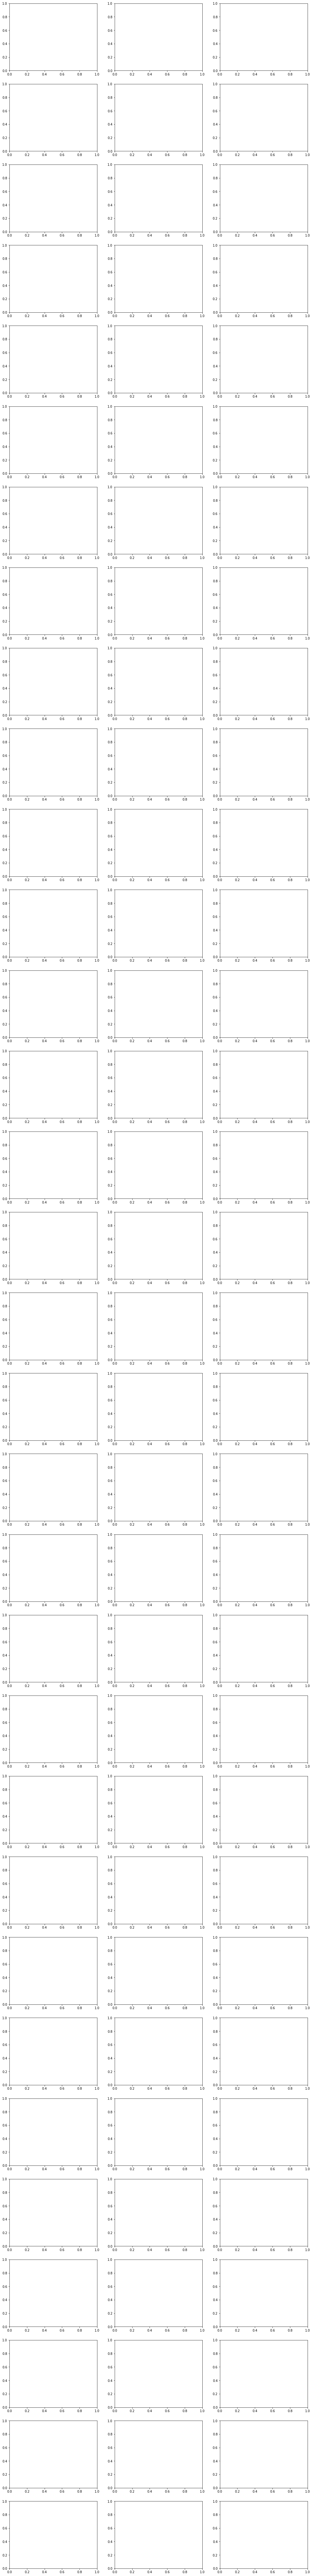

In [114]:
alpha = 15
l1 = 0.003
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = alpha , l1_ratio = l1))

In [12]:
model_regression = LinearRegressionBaselineModel(alpha = 15 , l1_ratio = 0.0001)
train(model_regression, train_df)
model_regression.model.coef_

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.88it/s]

Training done


array([-1.41490517e-04,  3.58676984e-04, -6.47379321e-04, -3.84141296e-04,
        0.00000000e+00, -4.90659691e-05, -0.00000000e+00,  4.51679217e-05,
       -6.67380378e-04,  4.23398077e-04,  4.54153240e-04, -3.98532447e-04,
       -0.00000000e+00, -5.08050421e-04,  1.14521781e-04, -3.05672341e-04,
        1.67760147e-05, -0.00000000e+00, -7.86606003e-04,  0.00000000e+00,
       -2.31355682e-05, -1.23008653e-04,  0.00000000e+00,  2.94856626e-04,
       -5.42433793e-04, -5.62178953e-04,  1.35403644e-04,  6.72121215e-04,
       -4.00115731e-04,  2.95050392e-04, -6.84278915e-04,  1.67619482e-05])

In [13]:
train_df_matrix = train_df.copy().drop(columns = 'date')
len(train_df_matrix.columns)

32

In [14]:
coeff_matrix = pd.DataFrame(zip(train_df_matrix.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

,features,coeff abs
0,[$]_[BSB]_Realized_Price,0.000787
1,[+]_[T]_Bitcoin_Price,0.000684
2,[+]_[NH]_Number_of_Addresses_with_Balance_10 -...,0.000672
3,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...,0.000667
4,[//]_[AV]_Stock-to-Flow_Ratio,0.000647
5,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,0.000562
6,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,0.000542
7,[//]_[BSB]_Liveliness,0.000508
8,[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Yea...,0.000454
9,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,0.000423


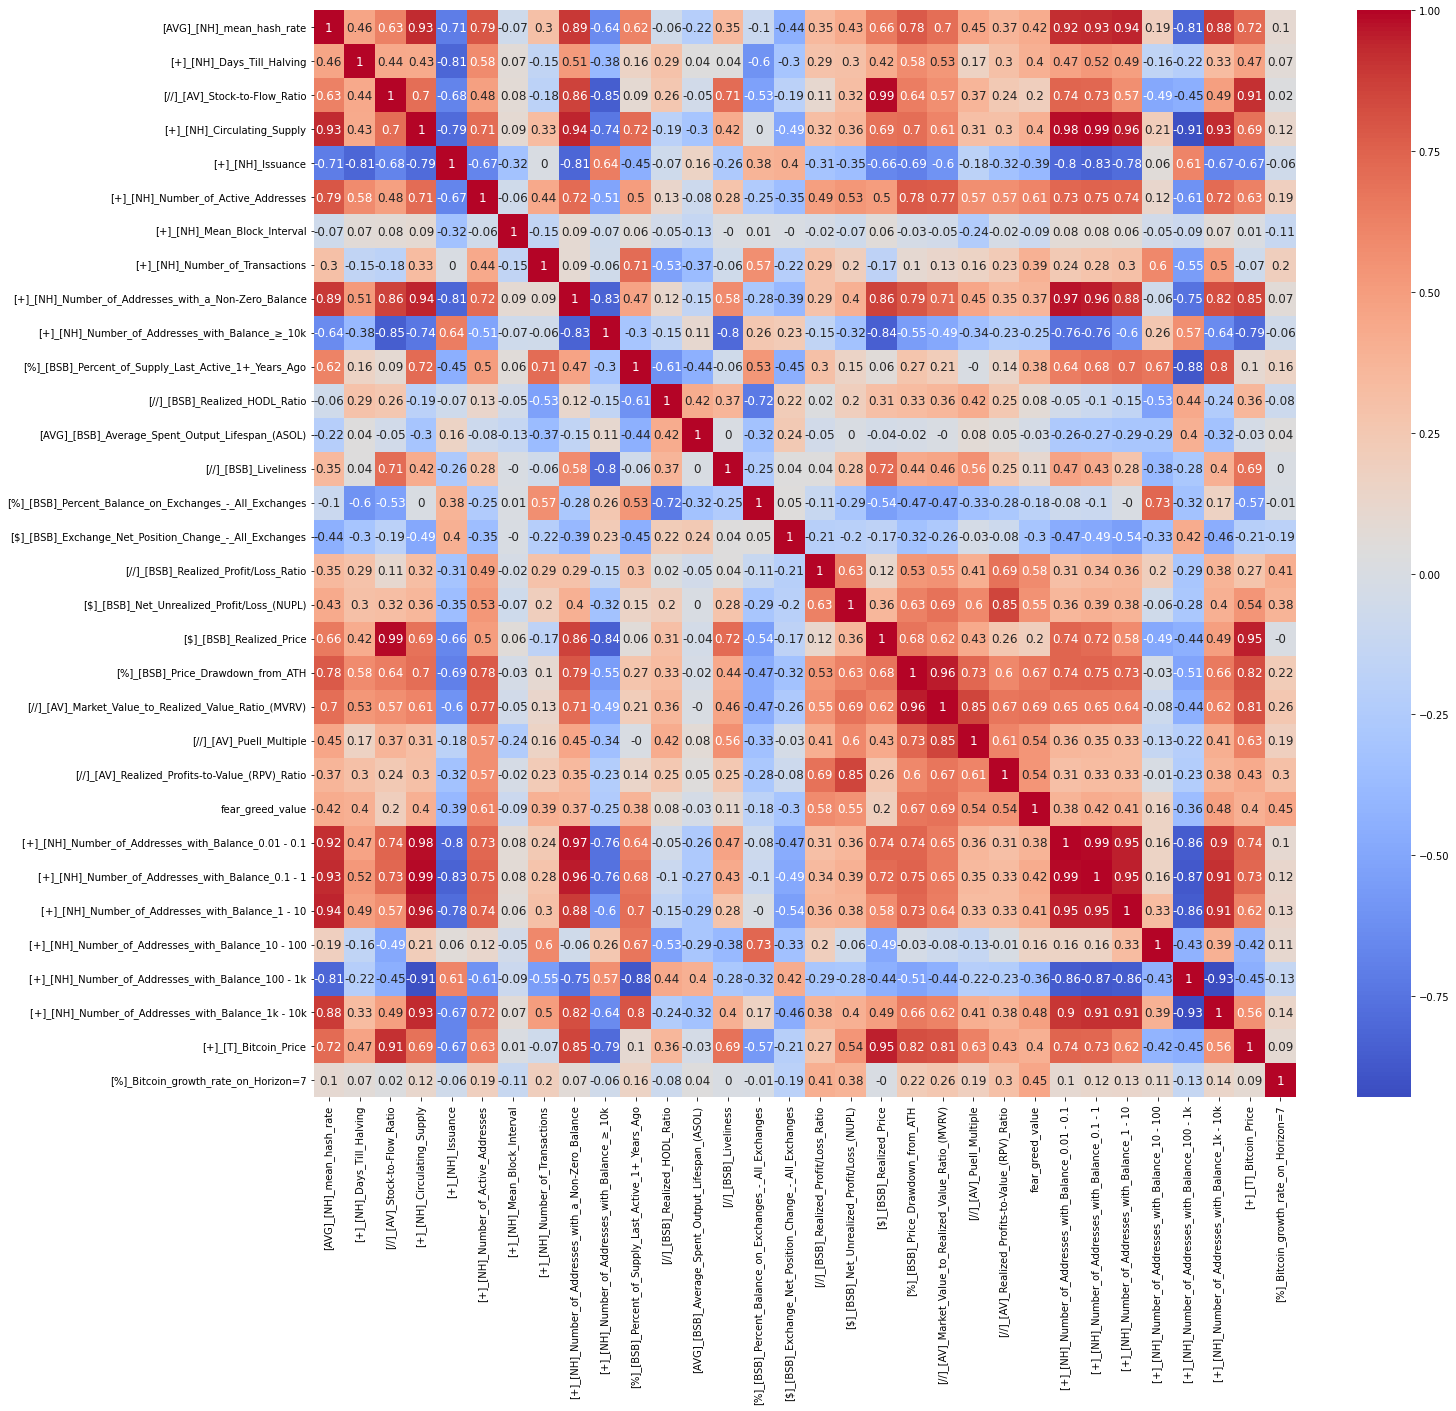

In [15]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df_matrix.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [16]:
train_df_matrix.corr().style.background_gradient(cmap='coolwarm')

,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago,[//]_[BSB]_Realized_HODL_Ratio,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),[//]_[BSB]_Liveliness,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_Exchanges,[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges,[//]_[BSB]_Realized_Profit/Loss_Ratio,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),[$]_[BSB]_Realized_Price,[%]_[BSB]_Price_Drawdown_from_ATH,[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV),[//]_[AV]_Puell_Multiple,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
[AVG]_[NH]_mean_hash_rate,1.000000,0.463162,0.630272,0.927254,-0.713023,0.786381,-0.073801,0.301860,0.891833,-0.643322,0.618119,-0.063496,-0.223503,0.347550,-0.101402,-0.437090,0.352117,0.431304,0.659304,0.780823,0.701315,0.454142,0.365043,0.423765,0.918904,0.930719,0.943290,0.194657,-0.805036,0.875091,0.720093,0.099333
[+]_[NH]_Days_Till_Halving,0.463162,1.000000,0.436686,0.429657,-0.805983,0.578631,0.065331,-0.149927,0.508994,-0.375368,0.157318,0.289766,0.043285,0.036267,-0.600147,-0.301794,0.293104,0.304748,0.421554,0.576468,0.527815,0.167947,0.304031,0.400049,0.468325,0.524134,0.490902,-0.162074,-0.221128,0.328114,0.468869,0.071926
[//]_[AV]_Stock-to-Flow_Ratio,0.630272,0.436686,1.000000,0.699625,-0.677524,0.480806,0.080088,-0.175301,0.862580,-0.854968,0.093267,0.264620,-0.049654,0.707004,-0.527314,-0.189448,0.111482,0.316725,0.987622,0.641979,0.567133,0.371118,0.237082,0.197502,0.741116,0.729136,0.567840,-0.491804,-0.454631,0.488282,0.907228,0.016407
[+]_[NH]_Circulating_Supply,0.927254,0.429657,0.699625,1.000000,-0.786063,0.714104,0.086624,0.326221,0.937293,-0.743304,0.722398,-0.186994,-0.300755,0.417440,0.001863,-0.487898,0.321092,0.364316,0.692872,0.700965,0.606103,0.311283,0.303428,0.395860,0.983193,0.988826,0.956484,0.213059,-0.910020,0.927786,0.692906,0.116837
[+]_[NH]_Issuance,-0.713023,-0.805983,-0.677524,-0.786063,1.000000,-0.668086,-0.320479,0.001770,-0.812060,0.642768,-0.448694,-0.071819,0.158712,-0.264509,0.377007,0.403575,-0.307451,-0.348981,-0.661812,-0.685705,-0.601294,-0.176091,-0.321128,-0.394968,-0.796507,-0.833646,-0.777212,0.063212,0.611146,-0.672511,-0.668621,-0.056325
[+]_[NH]_Number_of_Active_Addresses,0.786381,0.578631,0.480806,0.714104,-0.668086,1.000000,-0.056700,0.435906,0.721946,-0.508453,0.502838,0.127929,-0.076097,0.278546,-0.250836,-0.352549,0.489958,0.530693,0.502424,0.777987,0.767602,0.568191,0.568599,0.607500,0.727705,0.752795,0.742836,0.117266,-0.605357,0.724242,0.630793,0.188191
[+]_[NH]_Mean_Block_Interval,-0.073801,0.065331,0.080088,0.086624,-0.320479,-0.056700,1.000000,-0.151175,0.086287,-0.065396,0.060285,-0.048750,-0.127808,-0.002316,0.006697,-0.004033,-0.022181,-0.070075,0.062311,-0.031664,-0.048209,-0.236837,-0.023801,-0.088799,0.081083,0.082681,0.063204,-0.053364,-0.085416,0.067555,0.013641,-0.111179
[+]_[NH]_Number_of_Transactions,0.301860,-0.149927,-0.175301,0.326221,0.001770,0.435906,-0.151175,1.000000,0.094885,-0.061054,0.710053,-0.530574,-0.369062,-0.064793,0.573083,-0.216057,0.286628,0.204785,-0.173141,0.100348,0.127519,0.161841,0.231085,0.391686,0.242221,0.277518,0.299925,0.597508,-0.553054,0.500125,-0.067680,0.198020
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,0.891833,0.508994,0.862580,0.937293,-0.812060,0.721946,0.086287,0.094885,1.000000,-0.

### VIF index

In [17]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [18]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [19]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

,features,vif_index
0,[+]_[NH]_Circulating_Supply,541.09
1,[$]_[BSB]_Realized_Price,457.67
2,[//]_[AV]_Stock-to-Flow_Ratio,290.22
3,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,276.45
4,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...,257.74
5,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,237.33
6,[+]_[T]_Bitcoin_Price,172.11
7,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,163.09
8,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,100.08
9,[%]_[BSB]_Price_Drawdown_from_ATH,79.25


## Grid search and training

### Dummy model instanciating

In [20]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
val_score,score = train(dummy_model,train_df);
print(val_score,score)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 35.32it/s]

Training done
[0.06752, 0.08603, 0.11788, 0.13216, 0.14218, 0.13137, 0.11836, 0.10211, 0.09112, 0.07741, 0.06885, 0.16989, 0.18129, 0.19172, 0.08736, 0.06533, 0.05455, 0.06516, 0.0715, 0.06928, 0.07938, 0.10269, 0.12339, 0.1378, 0.13358, 0.15056, 0.13907, 0.14184, 0.12797, 0.11073, 0.10906, 0.09107] 0.11057


### Elastic Net Tuning

In [70]:
alpha = 15
l1 = 0.003
# Instanciate model
regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
# Train and Fit data using the crossval
train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 36.13it/s]

Training done


In [21]:
# Instanciate Grid Search
for counter in range(20):
    alpha = 0.015 * random()
    l1 = 0.002
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.17it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.77it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 26.04it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.97it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.09it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 28.93it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 27.32it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 29.32it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 27.95it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.36it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.34it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.63it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 23.41it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.88it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.59it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.76it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.97it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 24.55it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 22.19it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 24.89it/s]

Training done


### RNN Tuning

#### Tuning RNN

Epoch 1/250
4/4 [==============================] - 4s 270ms/step - loss: 0.0672 - mae: 0.0914 - val_loss: 0.0409 - val_mae: 0.0720
Epoch 2/250
4/4 [==============================] - 0s 118ms/step - loss: 0.0445 - mae: 0.0730 - val_loss: 0.0523 - val_mae: 0.0845
Epoch 3/250
4/4 [==============================] - 0s 124ms/step - loss: 0.0462 - mae: 0.0747 - val_loss: 0.0310 - val_mae: 0.0713
Epoch 4/250
4/4 [==============================] - 0s 116ms/step - loss: 0.0396 - mae: 0.0710 - val_loss: 0.0421 - val_mae: 0.0755
Epoch 5/250
4/4 [==============================] - 0s 111ms/step - loss: 0.0332 - mae: 0.0666 - val_loss: 0.0480 - val_mae: 0.0833
Epoch 6/250
4/4 [==============================] - 0s 111ms/step - loss: 0.0447 - mae: 0.0755 - val_loss: 0.0500 - val_mae: 0.0846
Epoch 7/250
4/4 [==============================] - 0s 113ms/step - loss: 0.0300 - mae: 0.0647 - val_loss: 0.0401 - val_mae: 0.0792
Epoch 8/250
4/4 [==============================] - 0s 111ms/step - loss: 0.0276 - m

Epoch 13/250
4/4 [==============================] - 1s 146ms/step - loss: 0.0240 - mae: 0.0614 - val_loss: 0.0128 - val_mae: 0.0365
Epoch 14/250
4/4 [==============================] - 1s 185ms/step - loss: 0.0280 - mae: 0.0621 - val_loss: 0.1565 - val_mae: 0.1435
Epoch 15/250
4/4 [==============================] - 1s 146ms/step - loss: 0.0542 - mae: 0.0761 - val_loss: 0.0172 - val_mae: 0.0415
Epoch 16/250
4/4 [==============================] - 1s 153ms/step - loss: 0.0217 - mae: 0.0593 - val_loss: 0.0266 - val_mae: 0.0524
Epoch 17/250
4/4 [==============================] - 1s 143ms/step - loss: 0.0205 - mae: 0.0575 - val_loss: 0.0406 - val_mae: 0.0666
Epoch 18/250
4/4 [==============================] - 1s 189ms/step - loss: 0.0249 - mae: 0.0616 - val_loss: 0.0190 - val_mae: 0.0444
Epoch 19/250
4/4 [==============================] - 1s 125ms/step - loss: 0.0262 - mae: 0.0598 - val_loss: 0.0562 - val_mae: 0.0801
Epoch 20/250
4/4 [==============================] - 1s 148ms/step - loss: 0.

4/4 [==============================] - 0s 113ms/step - loss: 0.0275 - mae: 0.0538 - val_loss: 0.0601 - val_mae: 0.0890
Epoch 14/250
4/4 [==============================] - 0s 112ms/step - loss: 0.0258 - mae: 0.0534 - val_loss: 0.0458 - val_mae: 0.0856
Epoch 15/250
4/4 [==============================] - 0s 112ms/step - loss: 0.0264 - mae: 0.0542 - val_loss: 0.0425 - val_mae: 0.0791
Epoch 16/250
4/4 [==============================] - 0s 110ms/step - loss: 0.0228 - mae: 0.0488 - val_loss: 0.0424 - val_mae: 0.0833
Epoch 17/250
4/4 [==============================] - 0s 112ms/step - loss: 0.0288 - mae: 0.0540 - val_loss: 0.1313 - val_mae: 0.1144
Epoch 18/250
4/4 [==============================] - 0s 111ms/step - loss: 0.0253 - mae: 0.0527 - val_loss: 0.0423 - val_mae: 0.0836
Epoch 19/250
4/4 [==============================] - 0s 110ms/step - loss: 0.0231 - mae: 0.0499 - val_loss: 0.0898 - val_mae: 0.0980
Epoch 20/250
4/4 [==============================] - 0s 110ms/step - loss: 0.0212 - mae: 0

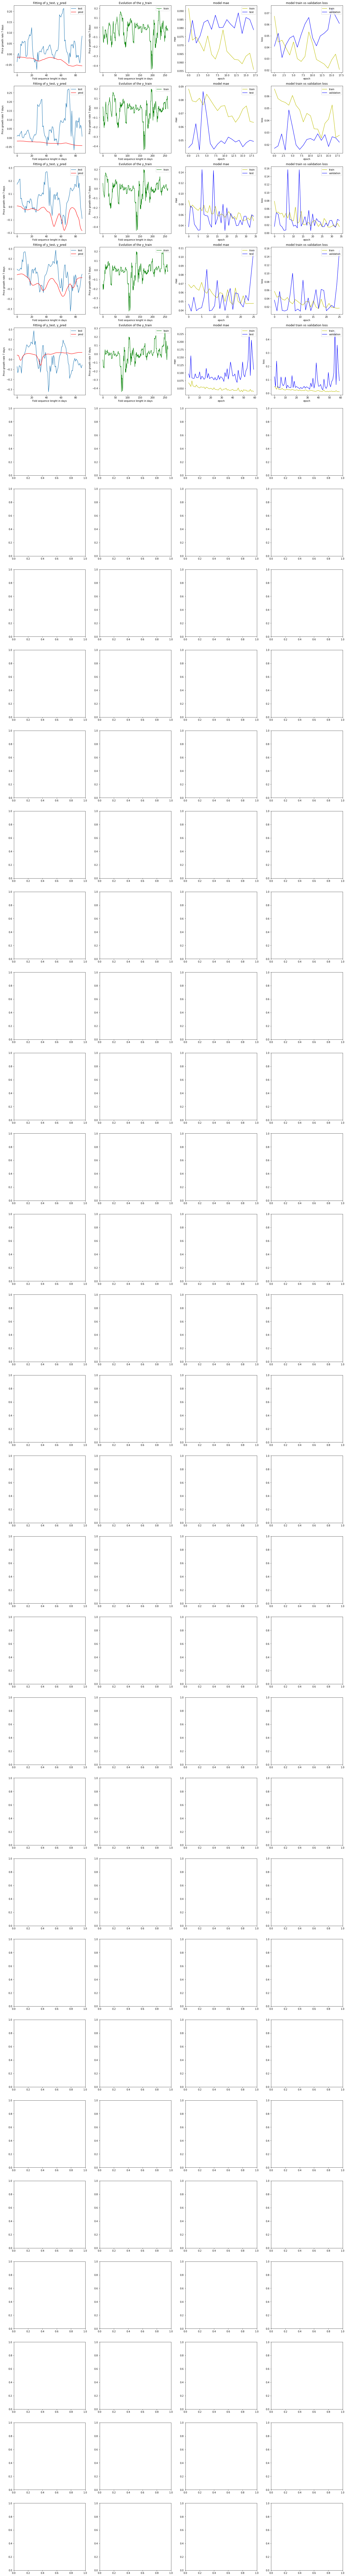

In [159]:
l1_rnn = 0.01653480436240602
l2_rnn = 0.0792386474

plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, RnnDlModel_test(L1 = l1_rnn, L2 = l2_rnn, epochs = 250, patience = 15))



#### to save in csv

In [42]:
#Instanciate Grid Search
for counter in range(1):
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel_test(L1 = l1_rnn, L2 = l2_rnn, epochs = 20, patience = 5)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df);

  0%|                                                    | 0/32 [00:00<?, ?it/s]

Epoch 1/20
4/4 [==============================] - 6s 395ms/step - loss: 0.0120 - mae: 0.0835 - val_loss: 0.0093 - val_mae: 0.0741
Epoch 2/20
4/4 [==============================] - 1s 164ms/step - loss: 0.0103 - mae: 0.0750 - val_loss: 0.0092 - val_mae: 0.0738
Epoch 3/20
4/4 [==============================] - 1s 215ms/step - loss: 0.0100 - mae: 0.0721 - val_loss: 0.0093 - val_mae: 0.0748
Epoch 4/20
4/4 [==============================] - 1s 210ms/step - loss: 0.0096 - mae: 0.0745 - val_loss: 0.0094 - val_mae: 0.0757
Epoch 5/20
4/4 [==============================] - 1s 210ms/step - loss: 0.0096 - mae: 0.0750 - val_loss: 0.0108 - val_mae: 0.0837
Epoch 6/20
4/4 [==============================] - 1s 202ms/step - loss: 0.0090 - mae: 0.0747 - val_loss: 0.0093 - val_mae: 0.0764
Epoch 7/20
4/4 [==============================] - 1s 217ms/step - loss: 0.0109 - mae: 0.0799 - val_loss: 0.0089 - val_mae: 0.0737
Epoch 8/20
4/4 [==============================] - 1s 207ms/step - loss: 0.0089 - mae: 0.06

  3%|█▍                                          | 1/32 [00:16<08:25, 16.31s/it]

Epoch 1/20
4/4 [==============================] - 6s 417ms/step - loss: 0.0119 - mae: 0.0775 - val_loss: 0.0033 - val_mae: 0.0432
Epoch 2/20
4/4 [==============================] - 1s 172ms/step - loss: 0.0114 - mae: 0.0797 - val_loss: 0.0034 - val_mae: 0.0440
Epoch 3/20
4/4 [==============================] - 1s 214ms/step - loss: 0.0113 - mae: 0.0799 - val_loss: 0.0039 - val_mae: 0.0478
Epoch 4/20
4/4 [==============================] - 1s 203ms/step - loss: 0.0112 - mae: 0.0806 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 5/20
4/4 [==============================] - 1s 225ms/step - loss: 0.0111 - mae: 0.0803 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 6/20
4/4 [==============================] - 1s 203ms/step - loss: 0.0108 - mae: 0.0803 - val_loss: 0.0031 - val_mae: 0.0424
Epoch 7/20
4/4 [==============================] - 1s 229ms/step - loss: 0.0111 - mae: 0.0791 - val_loss: 0.0052 - val_mae: 0.0571
Epoch 8/20
4/4 [==============================] - 1s 214ms/step - loss: 0.0104 - mae: 0.08

  6%|██▊                                         | 2/32 [00:31<07:43, 15.44s/it]

Epoch 1/20
4/4 [==============================] - 6s 390ms/step - loss: 0.0108 - mae: 0.0718 - val_loss: 0.0028 - val_mae: 0.0414
Epoch 2/20
4/4 [==============================] - 1s 164ms/step - loss: 0.0103 - mae: 0.0723 - val_loss: 0.0054 - val_mae: 0.0642
Epoch 3/20
4/4 [==============================] - 1s 199ms/step - loss: 0.0102 - mae: 0.0759 - val_loss: 0.0021 - val_mae: 0.0361
Epoch 4/20
4/4 [==============================] - 1s 211ms/step - loss: 0.0099 - mae: 0.0752 - val_loss: 0.0036 - val_mae: 0.0494
Epoch 5/20
4/4 [==============================] - 1s 215ms/step - loss: 0.0089 - mae: 0.0702 - val_loss: 0.0054 - val_mae: 0.0646
Epoch 6/20
4/4 [==============================] - 1s 212ms/step - loss: 0.0086 - mae: 0.0723 - val_loss: 0.0017 - val_mae: 0.0317
Epoch 7/20
4/4 [==============================] - 1s 204ms/step - loss: 0.0089 - mae: 0.0663 - val_loss: 0.0054 - val_mae: 0.0650
Epoch 8/20
4/4 [==============================] - 1s 200ms/step - loss: 0.0076 - mae: 0.06

  9%|████▏                                       | 3/32 [00:53<08:55, 18.45s/it]

Epoch 1/20
4/4 [==============================] - 6s 385ms/step - loss: 0.0096 - mae: 0.0638 - val_loss: 0.0081 - val_mae: 0.0651
Epoch 2/20
4/4 [==============================] - 1s 162ms/step - loss: 0.0093 - mae: 0.0665 - val_loss: 0.0085 - val_mae: 0.0681
Epoch 3/20
4/4 [==============================] - 1s 200ms/step - loss: 0.0092 - mae: 0.0676 - val_loss: 0.0089 - val_mae: 0.0709
Epoch 4/20
4/4 [==============================] - 1s 217ms/step - loss: 0.0091 - mae: 0.0673 - val_loss: 0.0062 - val_mae: 0.0509
Epoch 5/20
4/4 [==============================] - 1s 206ms/step - loss: 0.0091 - mae: 0.0662 - val_loss: 0.0068 - val_mae: 0.0553
Epoch 6/20
4/4 [==============================] - 1s 219ms/step - loss: 0.0089 - mae: 0.0668 - val_loss: 0.0055 - val_mae: 0.0452
Epoch 7/20
4/4 [==============================] - 1s 202ms/step - loss: 0.0083 - mae: 0.0663 - val_loss: 0.0040 - val_mae: 0.0402
Epoch 8/20
4/4 [==============================] - 1s 213ms/step - loss: 0.0091 - mae: 0.06

 12%|█████▌                                      | 4/32 [01:08<08:06, 17.36s/it]

Epoch 1/20
4/4 [==============================] - 5s 225ms/step - loss: 0.0090 - mae: 0.0587 - val_loss: 0.0129 - val_mae: 0.0840
Epoch 2/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0090 - mae: 0.0606 - val_loss: 0.0140 - val_mae: 0.0881
Epoch 3/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0091 - mae: 0.0609 - val_loss: 0.0148 - val_mae: 0.0916
Epoch 4/20
4/4 [==============================] - 0s 126ms/step - loss: 0.0087 - mae: 0.0596 - val_loss: 0.0155 - val_mae: 0.0945
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0084 - mae: 0.0612 - val_loss: 0.0164 - val_mae: 0.0989
Epoch 6/20
4/4 [==============================] - 1s 138ms/step - loss: 0.0081 - mae: 0.0607 - val_loss: 0.0143 - val_mae: 0.0895


 16%|██████▉                                     | 5/32 [01:17<06:19, 14.07s/it]

Epoch 1/20
4/4 [==============================] - 3s 223ms/step - loss: 0.0096 - mae: 0.0615 - val_loss: 0.0181 - val_mae: 0.1161
Epoch 2/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0094 - mae: 0.0626 - val_loss: 0.0188 - val_mae: 0.1186
Epoch 3/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0091 - mae: 0.0619 - val_loss: 0.0160 - val_mae: 0.1080
Epoch 4/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0085 - mae: 0.0601 - val_loss: 0.0136 - val_mae: 0.0988
Epoch 5/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0084 - mae: 0.0608 - val_loss: 0.0147 - val_mae: 0.1030
Epoch 6/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0082 - mae: 0.0607 - val_loss: 0.0157 - val_mae: 0.1066
Epoch 7/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0081 - mae: 0.0626 - val_loss: 0.0134 - val_mae: 0.0981
Epoch 8/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0076 - mae: 0.06

 19%|████████▎                                   | 6/32 [01:30<05:56, 13.73s/it]

Epoch 1/20
4/4 [==============================] - 4s 224ms/step - loss: 0.0118 - mae: 0.0735 - val_loss: 0.0184 - val_mae: 0.1100
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0115 - mae: 0.0750 - val_loss: 0.0149 - val_mae: 0.1005
Epoch 3/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0083 - mae: 0.0637 - val_loss: 0.0148 - val_mae: 0.1001
Epoch 4/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0080 - mae: 0.0646 - val_loss: 0.0234 - val_mae: 0.1247
Epoch 5/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0121 - mae: 0.0845 - val_loss: 0.0158 - val_mae: 0.1035
Epoch 6/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0078 - mae: 0.0654 - val_loss: 0.0180 - val_mae: 0.1102
Epoch 7/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0076 - mae: 0.0659 - val_loss: 0.0175 - val_mae: 0.1087
Epoch 8/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0078 - mae: 0.06

 22%|█████████▋                                  | 7/32 [01:37<04:53, 11.75s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0084 - mae: 0.0704 - val_loss: 0.0145 - val_mae: 0.0958
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0080 - mae: 0.0686 - val_loss: 0.0282 - val_mae: 0.1408
Epoch 3/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0081 - mae: 0.0693 - val_loss: 0.0185 - val_mae: 0.1106
Epoch 4/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0074 - mae: 0.0652 - val_loss: 0.0210 - val_mae: 0.1198
Epoch 5/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0071 - mae: 0.0647 - val_loss: 0.0198 - val_mae: 0.1153
Epoch 6/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0070 - mae: 0.0629 - val_loss: 0.0132 - val_mae: 0.0913
Epoch 7/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0073 - mae: 0.0644 - val_loss: 0.0248 - val_mae: 0.1313
Epoch 8/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0069 - mae: 0.06

 25%|███████████                                 | 8/32 [01:46<04:20, 10.85s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0082 - mae: 0.0667 - val_loss: 0.0066 - val_mae: 0.0648
Epoch 2/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0078 - mae: 0.0662 - val_loss: 0.0065 - val_mae: 0.0632
Epoch 3/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0080 - mae: 0.0652 - val_loss: 0.0070 - val_mae: 0.0697
Epoch 4/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0075 - mae: 0.0645 - val_loss: 0.0100 - val_mae: 0.0854
Epoch 5/20
4/4 [==============================] - 1s 122ms/step - loss: 0.0078 - mae: 0.0648 - val_loss: 0.0065 - val_mae: 0.0621
Epoch 6/20
4/4 [==============================] - 1s 139ms/step - loss: 0.0077 - mae: 0.0651 - val_loss: 0.0071 - val_mae: 0.0699
Epoch 7/20
4/4 [==============================] - 1s 163ms/step - loss: 0.0074 - mae: 0.0648 - val_loss: 0.0065 - val_mae: 0.0610
Epoch 8/20
4/4 [==============================] - 1s 136ms/step - loss: 0.0068 - mae: 0.06

 28%|████████████▍                               | 9/32 [01:55<03:56, 10.28s/it]

Epoch 1/20
4/4 [==============================] - 4s 231ms/step - loss: 0.0107 - mae: 0.0782 - val_loss: 0.0099 - val_mae: 0.0686
Epoch 2/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0086 - mae: 0.0713 - val_loss: 0.0080 - val_mae: 0.0568
Epoch 3/20
4/4 [==============================] - 1s 127ms/step - loss: 0.0090 - mae: 0.0717 - val_loss: 0.0080 - val_mae: 0.0567
Epoch 4/20
4/4 [==============================] - 1s 128ms/step - loss: 0.0087 - mae: 0.0698 - val_loss: 0.0078 - val_mae: 0.0555
Epoch 5/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0094 - mae: 0.0725 - val_loss: 0.0082 - val_mae: 0.0582
Epoch 6/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0092 - mae: 0.0710 - val_loss: 0.0089 - val_mae: 0.0624
Epoch 7/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0086 - mae: 0.0715 - val_loss: 0.0084 - val_mae: 0.0597
Epoch 8/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0080 - mae: 0.06

 31%|█████████████▍                             | 10/32 [02:03<03:31,  9.60s/it]

Epoch 1/20
4/4 [==============================] - 4s 226ms/step - loss: 0.0109 - mae: 0.0775 - val_loss: 0.0054 - val_mae: 0.0565
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0108 - mae: 0.0770 - val_loss: 0.0055 - val_mae: 0.0573
Epoch 3/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0107 - mae: 0.0768 - val_loss: 0.0056 - val_mae: 0.0584
Epoch 4/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0106 - mae: 0.0767 - val_loss: 0.0054 - val_mae: 0.0571
Epoch 5/20
4/4 [==============================] - 1s 172ms/step - loss: 0.0108 - mae: 0.0770 - val_loss: 0.0055 - val_mae: 0.0574
Epoch 6/20
4/4 [==============================] - 1s 123ms/step - loss: 0.0108 - mae: 0.0770 - val_loss: 0.0055 - val_mae: 0.0580


 34%|██████████████▊                            | 11/32 [02:10<03:05,  8.84s/it]

Epoch 1/20
4/4 [==============================] - 4s 227ms/step - loss: 0.0112 - mae: 0.0806 - val_loss: 0.0055 - val_mae: 0.0539
Epoch 2/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0111 - mae: 0.0811 - val_loss: 0.0053 - val_mae: 0.0527
Epoch 3/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0111 - mae: 0.0809 - val_loss: 0.0050 - val_mae: 0.0510
Epoch 4/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0110 - mae: 0.0802 - val_loss: 0.0047 - val_mae: 0.0499
Epoch 5/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0108 - mae: 0.0795 - val_loss: 0.0048 - val_mae: 0.0503
Epoch 6/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0103 - mae: 0.0772 - val_loss: 0.0054 - val_mae: 0.0536
Epoch 7/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0098 - mae: 0.0754 - val_loss: 0.0103 - val_mae: 0.0839
Epoch 8/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0105 - mae: 0.07

 38%|████████████████▏                          | 12/32 [02:24<03:25, 10.30s/it]

Epoch 1/20
4/4 [==============================] - 4s 310ms/step - loss: 0.0117 - mae: 0.0844 - val_loss: 0.0033 - val_mae: 0.0431
Epoch 2/20
4/4 [==============================] - 0s 117ms/step - loss: 0.0113 - mae: 0.0820 - val_loss: 0.0025 - val_mae: 0.0413
Epoch 3/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0108 - mae: 0.0804 - val_loss: 0.0044 - val_mae: 0.0522
Epoch 4/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0108 - mae: 0.0786 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 5/20
4/4 [==============================] - 0s 116ms/step - loss: 0.0102 - mae: 0.0770 - val_loss: 0.0047 - val_mae: 0.0547
Epoch 6/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0095 - mae: 0.0747 - val_loss: 0.0046 - val_mae: 0.0539
Epoch 7/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0095 - mae: 0.0736 - val_loss: 0.0038 - val_mae: 0.0471


 41%|█████████████████▍                         | 13/32 [02:31<02:57,  9.32s/it]

Epoch 1/20
4/4 [==============================] - 3s 221ms/step - loss: 0.0093 - mae: 0.0721 - val_loss: 0.0042 - val_mae: 0.0549
Epoch 2/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0093 - mae: 0.0719 - val_loss: 0.0044 - val_mae: 0.0561
Epoch 3/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0093 - mae: 0.0715 - val_loss: 0.0047 - val_mae: 0.0574
Epoch 4/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0092 - mae: 0.0714 - val_loss: 0.0044 - val_mae: 0.0557
Epoch 5/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0093 - mae: 0.0715 - val_loss: 0.0043 - val_mae: 0.0552
Epoch 6/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0092 - mae: 0.0710 - val_loss: 0.0056 - val_mae: 0.0622


 44%|██████████████████▊                        | 14/32 [02:38<02:31,  8.42s/it]

Epoch 1/20
4/4 [==============================] - 4s 225ms/step - loss: 0.0078 - mae: 0.0652 - val_loss: 0.0547 - val_mae: 0.1420
Epoch 2/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0075 - mae: 0.0635 - val_loss: 0.0577 - val_mae: 0.1406
Epoch 3/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0072 - mae: 0.0622 - val_loss: 0.0522 - val_mae: 0.1456
Epoch 4/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0076 - mae: 0.0665 - val_loss: 0.0591 - val_mae: 0.1417
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0072 - mae: 0.0622 - val_loss: 0.0576 - val_mae: 0.1389
Epoch 6/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0070 - mae: 0.0624 - val_loss: 0.0531 - val_mae: 0.1413
Epoch 7/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0073 - mae: 0.0645 - val_loss: 0.0591 - val_mae: 0.1409
Epoch 8/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0069 - mae: 0.06

 47%|████████████████████▏                      | 15/32 [02:45<02:18,  8.16s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0066 - mae: 0.0607 - val_loss: 0.0616 - val_mae: 0.1481
Epoch 2/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0065 - mae: 0.0596 - val_loss: 0.0595 - val_mae: 0.1493
Epoch 3/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0065 - mae: 0.0595 - val_loss: 0.0617 - val_mae: 0.1481
Epoch 4/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0065 - mae: 0.0601 - val_loss: 0.0593 - val_mae: 0.1474
Epoch 5/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0061 - mae: 0.0574 - val_loss: 0.0635 - val_mae: 0.1485
Epoch 6/20
4/4 [==============================] - 1s 122ms/step - loss: 0.0068 - mae: 0.0614 - val_loss: 0.0609 - val_mae: 0.1486
Epoch 7/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0065 - mae: 0.0594 - val_loss: 0.0598 - val_mae: 0.1500
Epoch 8/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0065 - mae: 0.05

 50%|█████████████████████▌                     | 16/32 [02:53<02:09,  8.11s/it]

Epoch 1/20
4/4 [==============================] - 3s 225ms/step - loss: 0.0200 - mae: 0.0821 - val_loss: 0.0156 - val_mae: 0.1076
Epoch 2/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0200 - mae: 0.0860 - val_loss: 0.0137 - val_mae: 0.0996
Epoch 3/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0199 - mae: 0.0857 - val_loss: 0.0104 - val_mae: 0.0843
Epoch 4/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0199 - mae: 0.0811 - val_loss: 0.0136 - val_mae: 0.0989
Epoch 5/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0197 - mae: 0.0845 - val_loss: 0.0109 - val_mae: 0.0866
Epoch 6/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0197 - mae: 0.0827 - val_loss: 0.0080 - val_mae: 0.0727
Epoch 7/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0195 - mae: 0.0808 - val_loss: 0.0072 - val_mae: 0.0685
Epoch 8/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0194 - mae: 0.08

 53%|██████████████████████▊                    | 17/32 [03:06<02:24,  9.60s/it]

Epoch 1/20
4/4 [==============================] - 4s 221ms/step - loss: 0.0191 - mae: 0.0768 - val_loss: 0.0061 - val_mae: 0.0627
Epoch 2/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0189 - mae: 0.0770 - val_loss: 0.0065 - val_mae: 0.0635
Epoch 3/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0188 - mae: 0.0770 - val_loss: 0.0065 - val_mae: 0.0635
Epoch 4/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0188 - mae: 0.0769 - val_loss: 0.0065 - val_mae: 0.0635
Epoch 5/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0188 - mae: 0.0770 - val_loss: 0.0066 - val_mae: 0.0638
Epoch 6/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0187 - mae: 0.0771 - val_loss: 0.0067 - val_mae: 0.0639


 56%|████████████████████████▏                  | 18/32 [03:13<02:01,  8.71s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0196 - mae: 0.0819 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0196 - mae: 0.0819 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 3/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0196 - mae: 0.0812 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 4/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0196 - mae: 0.0814 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 5/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0195 - mae: 0.0812 - val_loss: 0.0012 - val_mae: 0.0256
Epoch 6/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0195 - mae: 0.0818 - val_loss: 0.0012 - val_mae: 0.0255
Epoch 7/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0194 - mae: 0.0823 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 8/20
4/4 [==============================] - 0s 117ms/step - loss: 0.0193 - mae: 0.08

 59%|█████████████████████████▌                 | 19/32 [03:22<01:55,  8.92s/it]

Epoch 1/20
4/4 [==============================] - 3s 221ms/step - loss: 0.0187 - mae: 0.0762 - val_loss: 0.0040 - val_mae: 0.0420
Epoch 2/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0185 - mae: 0.0773 - val_loss: 0.0031 - val_mae: 0.0372
Epoch 3/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0183 - mae: 0.0740 - val_loss: 0.0052 - val_mae: 0.0515
Epoch 4/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0182 - mae: 0.0746 - val_loss: 0.0029 - val_mae: 0.0371
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0183 - mae: 0.0739 - val_loss: 0.0030 - val_mae: 0.0371
Epoch 6/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0175 - mae: 0.0738 - val_loss: 0.0035 - val_mae: 0.0412
Epoch 7/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0171 - mae: 0.0737 - val_loss: 0.0029 - val_mae: 0.0379
Epoch 8/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0167 - mae: 0.07

 62%|██████████████████████████▉                | 20/32 [03:32<01:49,  9.10s/it]

Epoch 1/20
4/4 [==============================] - 3s 225ms/step - loss: 0.0185 - mae: 0.0754 - val_loss: 0.0060 - val_mae: 0.0557
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0184 - mae: 0.0745 - val_loss: 0.0060 - val_mae: 0.0559
Epoch 3/20
4/4 [==============================] - 0s 125ms/step - loss: 0.0184 - mae: 0.0747 - val_loss: 0.0059 - val_mae: 0.0551
Epoch 4/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0184 - mae: 0.0740 - val_loss: 0.0059 - val_mae: 0.0551
Epoch 5/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0184 - mae: 0.0741 - val_loss: 0.0059 - val_mae: 0.0551
Epoch 6/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0184 - mae: 0.0740 - val_loss: 0.0059 - val_mae: 0.0550
Epoch 7/20
4/4 [==============================] - 0s 126ms/step - loss: 0.0184 - mae: 0.0740 - val_loss: 0.0059 - val_mae: 0.0550
Epoch 8/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0184 - mae: 0.07

 66%|████████████████████████████▏              | 21/32 [03:41<01:39,  9.01s/it]

Epoch 1/20
4/4 [==============================] - 4s 224ms/step - loss: 0.0187 - mae: 0.0764 - val_loss: 0.0036 - val_mae: 0.0445
Epoch 2/20
4/4 [==============================] - 1s 163ms/step - loss: 0.0187 - mae: 0.0744 - val_loss: 0.0036 - val_mae: 0.0447
Epoch 3/20
4/4 [==============================] - 1s 129ms/step - loss: 0.0187 - mae: 0.0743 - val_loss: 0.0036 - val_mae: 0.0449
Epoch 4/20
4/4 [==============================] - 1s 137ms/step - loss: 0.0187 - mae: 0.0743 - val_loss: 0.0036 - val_mae: 0.0465
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0184 - mae: 0.0763 - val_loss: 0.0042 - val_mae: 0.0543
Epoch 6/20
4/4 [==============================] - 1s 128ms/step - loss: 0.0184 - mae: 0.0800 - val_loss: 0.0040 - val_mae: 0.0470


 69%|█████████████████████████████▌             | 22/32 [03:47<01:23,  8.35s/it]

Epoch 1/20
4/4 [==============================] - 4s 226ms/step - loss: 0.0187 - mae: 0.0742 - val_loss: 0.0030 - val_mae: 0.0441
Epoch 2/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0190 - mae: 0.0742 - val_loss: 0.0042 - val_mae: 0.0527
Epoch 3/20
4/4 [==============================] - 0s 125ms/step - loss: 0.0189 - mae: 0.0739 - val_loss: 0.0053 - val_mae: 0.0598
Epoch 4/20
4/4 [==============================] - 1s 121ms/step - loss: 0.0187 - mae: 0.0748 - val_loss: 0.0049 - val_mae: 0.0576
Epoch 5/20
4/4 [==============================] - 1s 145ms/step - loss: 0.0185 - mae: 0.0740 - val_loss: 0.0035 - val_mae: 0.0479
Epoch 6/20
4/4 [==============================] - 1s 165ms/step - loss: 0.0187 - mae: 0.0743 - val_loss: 0.0045 - val_mae: 0.0550


 72%|██████████████████████████████▉            | 23/32 [03:54<01:11,  7.96s/it]

Epoch 1/20
4/4 [==============================] - 5s 283ms/step - loss: 0.0044 - mae: 0.0497 - val_loss: 0.0055 - val_mae: 0.0652
Epoch 2/20
4/4 [==============================] - 1s 129ms/step - loss: 0.0040 - mae: 0.0472 - val_loss: 0.0057 - val_mae: 0.0663
Epoch 3/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0039 - mae: 0.0470 - val_loss: 0.0047 - val_mae: 0.0598
Epoch 4/20
4/4 [==============================] - 1s 128ms/step - loss: 0.0038 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0534
Epoch 5/20
4/4 [==============================] - 1s 129ms/step - loss: 0.0039 - mae: 0.0484 - val_loss: 0.0041 - val_mae: 0.0551
Epoch 6/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0038 - mae: 0.0478 - val_loss: 0.0047 - val_mae: 0.0598
Epoch 7/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0038 - mae: 0.0465 - val_loss: 0.0057 - val_mae: 0.0659
Epoch 8/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0037 - mae: 0.04

 75%|████████████████████████████████▎          | 24/32 [04:04<01:07,  8.48s/it]

Epoch 1/20
4/4 [==============================] - 4s 232ms/step - loss: 0.0048 - mae: 0.0525 - val_loss: 0.0148 - val_mae: 0.1006
Epoch 2/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0043 - mae: 0.0505 - val_loss: 0.0137 - val_mae: 0.0977
Epoch 3/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0042 - mae: 0.0500 - val_loss: 0.0111 - val_mae: 0.0899
Epoch 4/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0042 - mae: 0.0512 - val_loss: 0.0123 - val_mae: 0.0938
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0041 - mae: 0.0500 - val_loss: 0.0112 - val_mae: 0.0904
Epoch 6/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0040 - mae: 0.0492 - val_loss: 0.0132 - val_mae: 0.0966
Epoch 7/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0040 - mae: 0.0489 - val_loss: 0.0140 - val_mae: 0.0987
Epoch 8/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0040 - mae: 0.04

 78%|█████████████████████████████████▌         | 25/32 [04:15<01:03,  9.08s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0048 - mae: 0.0526 - val_loss: 0.0172 - val_mae: 0.1103
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0044 - mae: 0.0515 - val_loss: 0.0168 - val_mae: 0.1081
Epoch 3/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0044 - mae: 0.0520 - val_loss: 0.0173 - val_mae: 0.1114
Epoch 4/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0042 - mae: 0.0492 - val_loss: 0.0169 - val_mae: 0.1084
Epoch 5/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0042 - mae: 0.0494 - val_loss: 0.0171 - val_mae: 0.1095
Epoch 6/20
4/4 [==============================] - 1s 126ms/step - loss: 0.0040 - mae: 0.0483 - val_loss: 0.0170 - val_mae: 0.1076
Epoch 7/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0040 - mae: 0.0474 - val_loss: 0.0170 - val_mae: 0.1087


 81%|██████████████████████████████████▉        | 26/32 [04:22<00:51,  8.55s/it]

Epoch 1/20
4/4 [==============================] - 4s 225ms/step - loss: 0.0080 - mae: 0.0663 - val_loss: 0.0170 - val_mae: 0.1103
Epoch 2/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0072 - mae: 0.0631 - val_loss: 0.0163 - val_mae: 0.1062
Epoch 3/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0069 - mae: 0.0622 - val_loss: 0.0185 - val_mae: 0.1186
Epoch 4/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0071 - mae: 0.0630 - val_loss: 0.0157 - val_mae: 0.1022
Epoch 5/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0067 - mae: 0.0622 - val_loss: 0.0158 - val_mae: 0.1026
Epoch 6/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0067 - mae: 0.0619 - val_loss: 0.0164 - val_mae: 0.1070
Epoch 7/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0068 - mae: 0.0624 - val_loss: 0.0157 - val_mae: 0.1017
Epoch 8/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0066 - mae: 0.06

 84%|████████████████████████████████████▎      | 27/32 [04:34<00:48,  9.60s/it]

Epoch 1/20
4/4 [==============================] - 4s 227ms/step - loss: 0.0121 - mae: 0.0865 - val_loss: 0.0204 - val_mae: 0.1146
Epoch 2/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0088 - mae: 0.0745 - val_loss: 0.0087 - val_mae: 0.0697
Epoch 3/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0084 - mae: 0.0718 - val_loss: 0.0220 - val_mae: 0.1208
Epoch 4/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0083 - mae: 0.0715 - val_loss: 0.0090 - val_mae: 0.0707
Epoch 5/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0085 - mae: 0.0722 - val_loss: 0.0144 - val_mae: 0.0927
Epoch 6/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0077 - mae: 0.0673 - val_loss: 0.0231 - val_mae: 0.1242
Epoch 7/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0085 - mae: 0.0719 - val_loss: 0.0169 - val_mae: 0.1008


 88%|█████████████████████████████████████▋     | 28/32 [04:41<00:35,  8.78s/it]

Epoch 1/20
4/4 [==============================] - 3s 224ms/step - loss: 0.0110 - mae: 0.0836 - val_loss: 0.0120 - val_mae: 0.0811
Epoch 2/20
4/4 [==============================] - 1s 142ms/step - loss: 0.0097 - mae: 0.0764 - val_loss: 0.0153 - val_mae: 0.0920
Epoch 3/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0098 - mae: 0.0761 - val_loss: 0.0127 - val_mae: 0.0834
Epoch 4/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0097 - mae: 0.0757 - val_loss: 0.0117 - val_mae: 0.0802
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0097 - mae: 0.0767 - val_loss: 0.0130 - val_mae: 0.0842
Epoch 6/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0097 - mae: 0.0758 - val_loss: 0.0128 - val_mae: 0.0836
Epoch 7/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0095 - mae: 0.0750 - val_loss: 0.0141 - val_mae: 0.0879
Epoch 8/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0094 - mae: 0.07

 91%|██████████████████████████████████████▉    | 29/32 [04:49<00:25,  8.59s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0103 - mae: 0.0798 - val_loss: 0.0447 - val_mae: 0.1706
Epoch 2/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0118 - mae: 0.0846 - val_loss: 0.0329 - val_mae: 0.1382
Epoch 3/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0095 - mae: 0.0744 - val_loss: 0.0247 - val_mae: 0.1145
Epoch 4/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0092 - mae: 0.0736 - val_loss: 0.0245 - val_mae: 0.1139
Epoch 5/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0091 - mae: 0.0739 - val_loss: 0.0245 - val_mae: 0.1139
Epoch 6/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0090 - mae: 0.0739 - val_loss: 0.0250 - val_mae: 0.1164
Epoch 7/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0091 - mae: 0.0734 - val_loss: 0.0254 - val_mae: 0.1181
Epoch 8/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0092 - mae: 0.07

 94%|████████████████████████████████████████▎  | 30/32 [05:02<00:20, 10.06s/it]

Epoch 1/20
4/4 [==============================] - 4s 223ms/step - loss: 0.0144 - mae: 0.0935 - val_loss: 0.0102 - val_mae: 0.0736
Epoch 2/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0140 - mae: 0.0918 - val_loss: 0.0098 - val_mae: 0.0712
Epoch 3/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0147 - mae: 0.0950 - val_loss: 0.0095 - val_mae: 0.0700
Epoch 4/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0128 - mae: 0.0873 - val_loss: 0.0084 - val_mae: 0.0648
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0129 - mae: 0.0899 - val_loss: 0.0085 - val_mae: 0.0653
Epoch 6/20
4/4 [==============================] - 0s 120ms/step - loss: 0.0120 - mae: 0.0865 - val_loss: 0.0096 - val_mae: 0.0757
Epoch 7/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0120 - mae: 0.0853 - val_loss: 0.0087 - val_mae: 0.0666
Epoch 8/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0141 - mae: 0.09

 97%|█████████████████████████████████████████▋ | 31/32 [05:11<00:09,  9.46s/it]

Epoch 1/20
4/4 [==============================] - 4s 230ms/step - loss: 0.0179 - mae: 0.1049 - val_loss: 0.0107 - val_mae: 0.0825
Epoch 2/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0160 - mae: 0.0992 - val_loss: 0.0103 - val_mae: 0.0824
Epoch 3/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0152 - mae: 0.0951 - val_loss: 0.0106 - val_mae: 0.0825
Epoch 4/20
4/4 [==============================] - 0s 123ms/step - loss: 0.0149 - mae: 0.0944 - val_loss: 0.0108 - val_mae: 0.0826
Epoch 5/20
4/4 [==============================] - 0s 125ms/step - loss: 0.0149 - mae: 0.0951 - val_loss: 0.0109 - val_mae: 0.0828
Epoch 6/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0145 - mae: 0.0941 - val_loss: 0.0108 - val_mae: 0.0825
Epoch 7/20
4/4 [==============================] - 0s 124ms/step - loss: 0.0144 - mae: 0.0915 - val_loss: 0.0108 - val_mae: 0.0828


100%|███████████████████████████████████████████| 32/32 [05:18<00:00,  9.94s/it]

Training done


### Exporting and viewing results

In [43]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

,name,fold_score,mean_score,min_score,max_score,hyperparams,date
20,LinearReg,"[0.06422, 0.08158, 0.10233, 0.10397, 0.0928, 0...",0.08007,0.03786,0.11896,"{'alpha': 15, 'l1_ratio': 0.0001}",09-03 12:29:18
46,RNN,"[0.08021, 0.07414, 0.15304, 0.09484, 0.09262, ...",0.08496,0.04367,0.15304,"{'L1': 0.09621870580119067, 'L2': 0.0459439662...",09-03 13:50:07
45,RNN,"[0.25442, 0.06626, 0.10818, 0.12145, 0.09141, ...",0.09662,0.04369,0.25442,"{'L1': 0.057297844739236325, 'L2': 0.021727812...",09-03 13:16:23
21,Dummy,"[0.06752, 0.08603, 0.11788, 0.13216, 0.14218, ...",0.11057,0.05455,0.19172,NaN,09-03 12:29:22
42,RNN,"[0.14024, 0.06254, 0.10764, 0.08193, 0.24885, ...",0.13397,0.05175,0.50838,"{'L1': 0.014348080048301116, 'L2': 0.075800478...",09-03 12:58:59
10,LinearReg,"[0.13612, 0.21353, 0.30214, 0.10699, 0.19859, ...",0.16727,0.04825,0.48190,"{'alpha': 0.0146728420498667, 'l1_ratio': 0.002}",09-03 12:24:17
38,LinearReg,"[0.13771, 0.21647, 0.30717, 0.10733, 0.20077, ...",0.16939,0.04850,0.48631,"{'alpha': 0.013972992093995074, 'l1_ratio': 0....",09-03 12:29:47
25,LinearReg,"[0.13809, 0.21718, 0.30844, 0.1074, 0.20131, 0...",0.16991,0.04856,0.48734,"{'alpha': 0.013810108835731945, 'l1_ratio': 0....",09-03 12:29:33
17,LinearReg,"[0.14206, 0.22432, 0.32162, 0.10804, 0.20692, ...",0.17525,0.04917,0.49749,"{'alpha': 0.012252161010179409, 'l1_ratio': 0....",09-03 12:24:24
11,LinearReg,"[0.14258, 0.22526, 0.32338, 0.10813, 0.20769, ...",0.17597,0.04925,0.49874,"{'alpha': 0.012059999245888445, 'l1_ratio': 0....",09-03 12:24:18


## (Optionnal) Plotting scores on cross validated models

In [ ]:
# Instanciate Grid Search
scores_regression = []
scores_baseline = []
scores_rnn = []
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    fold_score, score = train(regression_model,train_df)
    scores.append(score)
    # Instanciate model
    dummy_model = DummyModel()
    # Train and Fit data using the crossval
    train(dummy_model,train_df)
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

#Plotting
plt.plot(scores_regression, color = 'r', label = 'regression')
plt.plot(scores_baseline, color = 'b', label = 'last value')
plt.plot(scores_rnn, color = 'g', label = 'rnn')
plt.legend()
plt.title('Model scores comparison chart')


In [44]:
import json

alpha = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['alpha']
l1_ratio = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['l1_ratio']
print(alpha)
print(l1_ratio)


0.09826776612681243
0.001
